In [18]:
import random
import pandas as pd
import math
import copy
import matplotlib
import matplotlib.pyplot as plt

# Признаки и датасет

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Перебирались разные признаки

В итоге решили остановиться на этих в соответствии с корреляцией с целевой переменной

В датасете очень много категориальных признаков, с которыми линейная регрессия работает не очень. Пробовали кодировать one-hot-encoding и по количеству объектов с данным значением категориального признака. В итоге остановились на one-hot-encoding с несколькими из категориальных признаков.

# Предобработка (без нормализации)

In [20]:
data = pd.read_csv("drive/MyDrive/97729915_T_ONTIME_REPORTING.csv")
data = data.iloc[:, :-1]
data.sample(10)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE
428508,23,3,DL,13930,ORD,Illinois,10397,Georgia,1009,NaN,116.0,606.0
418315,23,3,OO,13930,ORD,Illinois,10990,Virginia,1701,33.0,120.0,566.0
37797,2,3,HA,12173,HNL,Hawaii,12982,Hawaii,513,-6.0,40.0,102.0
154926,9,3,AS,14747,SEA,Washington,14771,California,1600,49.0,125.0,679.0
487792,27,7,9E,11624,EYW,Florida,10397,Georgia,1335,-12.0,122.0,646.0
32113,2,3,AA,11057,CLT,North Carolina,14492,North Carolina,1636,-3.0,61.0,130.0
183144,10,4,UA,13930,ORD,Illinois,14683,Texas,1305,-6.0,187.0,1041.0
365893,20,7,DL,13487,MSP,Minnesota,14635,Florida,1015,-2.0,202.0,1416.0
371730,20,7,OO,13851,OKC,Oklahoma,11292,Colorado,1307,-11.0,111.0,495.0
573322,31,4,YV,11298,DFW,Texas,13256,Texas,1521,-4.0,89.0,469.0


In [21]:
print(data.shape)
data = data.dropna()
data = data.drop_duplicates()
data.shape

(583985, 12)


(567629, 12)

In [22]:
data.isna().sum(axis=0)

DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
ORIGIN_AIRPORT_ID    0
ORIGIN               0
ORIGIN_STATE_NM      0
DEST_AIRPORT_ID      0
DEST_STATE_NM        0
CRS_DEP_TIME         0
DEP_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
dtype: int64

In [23]:
# Конвертируем время hhmm в минуты
time = data['CRS_DEP_TIME'].copy()
data['CRS_DEP_TIME'] = time % 100 + 60 * (time // 100)

In [24]:
y = data['DEP_DELAY']
y = y.tolist()

#Изучение данных

(array([5.53794e+05, 1.14890e+04, 1.44300e+03, 3.61000e+02, 1.91000e+02,
        1.75000e+02, 1.02000e+02, 4.40000e+01, 2.50000e+01, 5.00000e+00]),
 array([ -47. ,  122.8,  292.6,  462.4,  632.2,  802. ,  971.8, 1141.6,
        1311.4, 1481.2, 1651. ]),
 <a list of 10 Patch objects>)

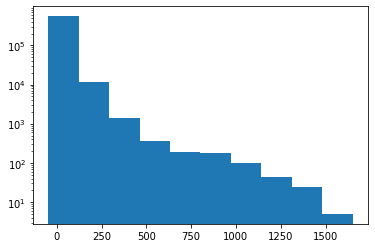

In [25]:
plt.hist(data["DEP_DELAY"], log=True)

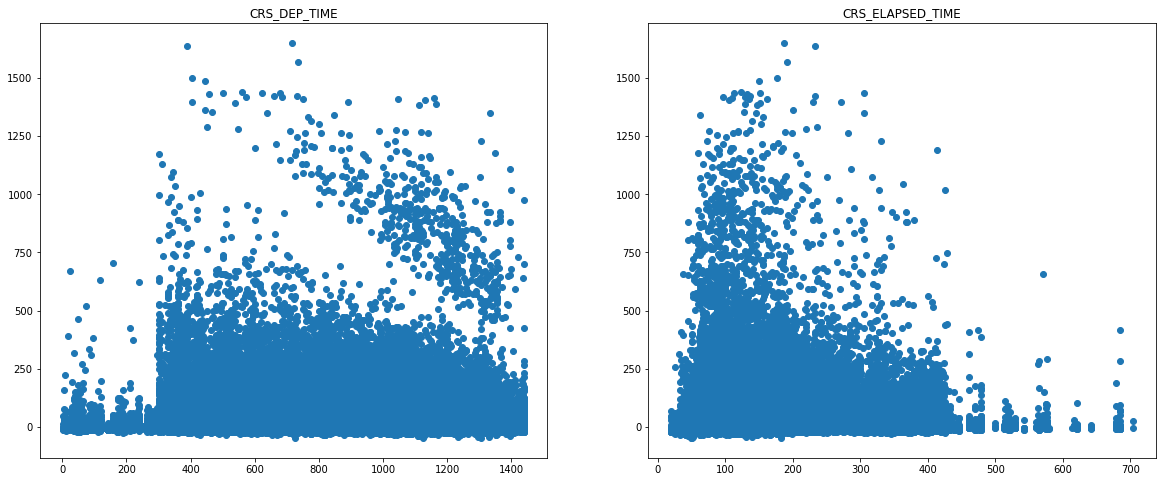

In [26]:
numerical = ["CRS_DEP_TIME", 'CRS_ELAPSED_TIME']
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for i in range(2):
    col_name = numerical[i]
    x_i = data[col_name]
    axs[i].scatter(x_i, y)
    axs[i].set_title(col_name)

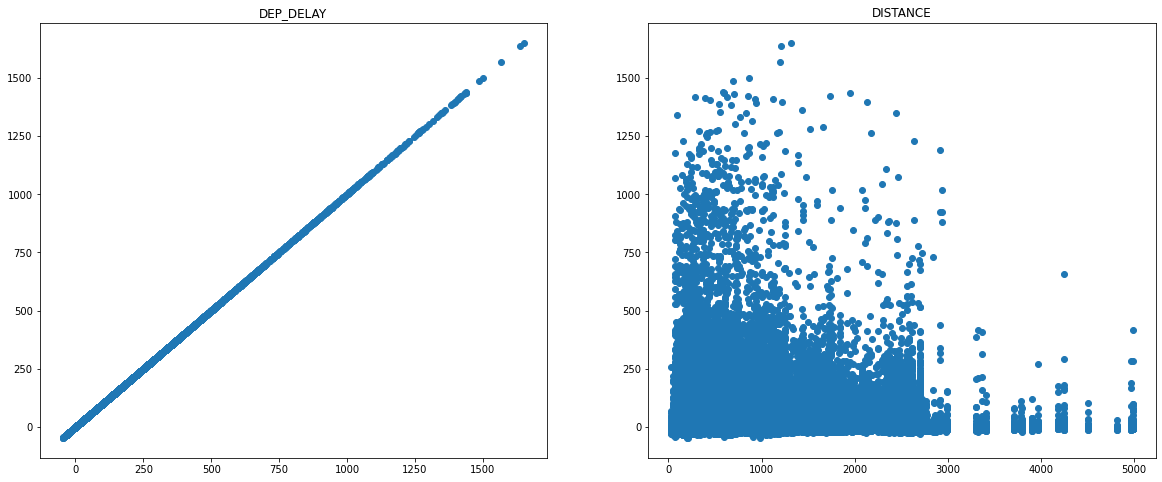

In [27]:
numerical = ["DEP_DELAY", 'DISTANCE']
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for i in range(2):
    col_name = numerical[i]
    x_i = data[col_name]
    axs[i].scatter(x_i, y)
    axs[i].set_title(col_name)

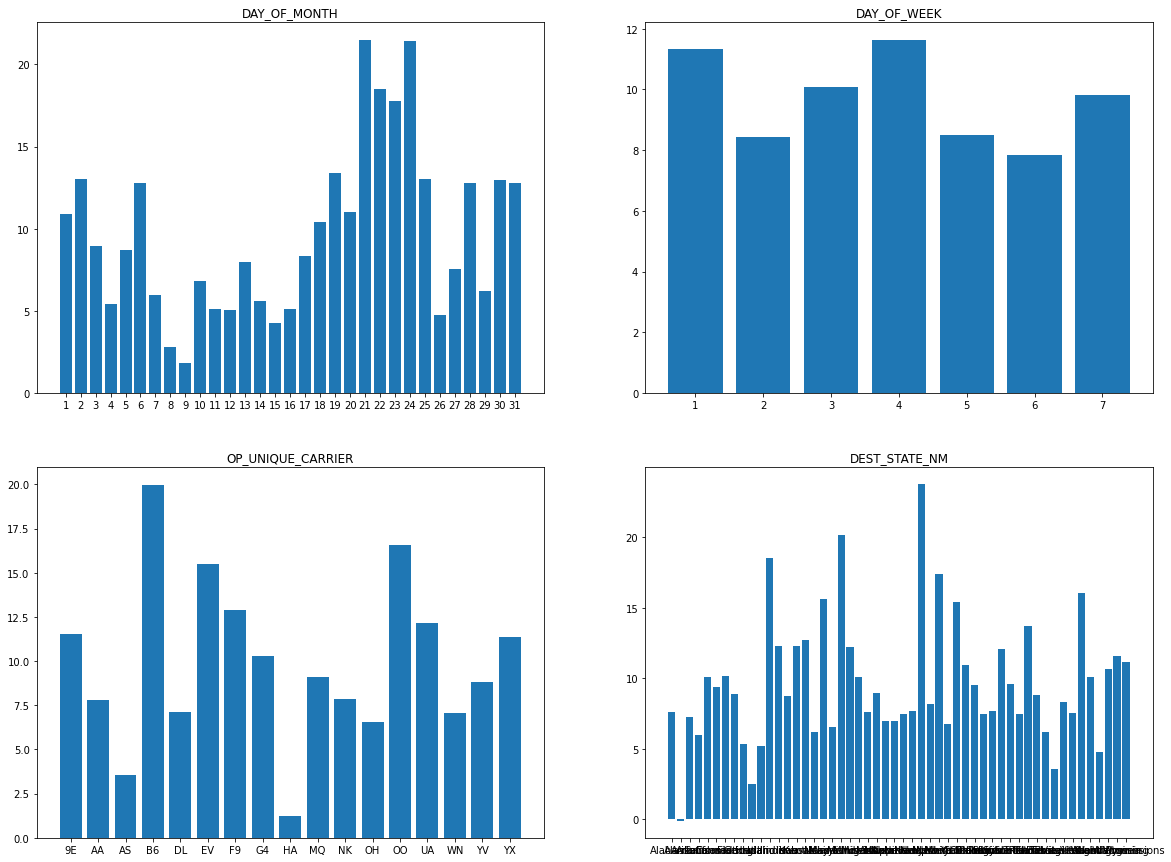

In [28]:
periodical = ["DAY_OF_MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "DEST_STATE_NM"]
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i in range(4):
    ax = axs[i//2, i%2]
    col_name = periodical[i]
    agg = data.copy().groupby(col_name).agg("mean").sort_values(by=[col_name])
    ax.bar(agg.index.astype("str"), agg["DEP_DELAY"])
    ax.set_title(col_name)

In [ ]:
data.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE
0,1,2,9E,11953,GNV,Florida,10397,Georgia,360,1.0,83.0,300.0
1,1,2,9E,13487,MSP,Minnesota,11193,Kentucky,844,-5.0,125.0,596.0
2,1,2,9E,11433,DTW,Michigan,11193,Kentucky,740,-5.0,85.0,229.0
3,1,2,9E,15249,TLH,Florida,10397,Georgia,927,-6.0,72.0,223.0
4,1,2,9E,10397,ATL,Georgia,11778,Arkansas,1142,-15.0,123.0,579.0


In [29]:
for_one_hot = ['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER']

for col_name in for_one_hot:
    unique_values = data[col_name].unique()
    for val in unique_values:
        mask = data[col_name] == val
        new_col_name = f"{col_name}__{val}"
        data[new_col_name] = 0
        data.loc[mask, new_col_name] = 1
        print(col_name + " OK")
        
data.head()

DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
DAY_OF_WEEK OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK
OP_UNIQUE_CARRIER OK


,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__OH,OP_UNIQUE_CARRIER__B6,OP_UNIQUE_CARRIER__YV,OP_UNIQUE_CARRIER__EV,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__HA,OP_UNIQUE_CARRIER__NK,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__AS,OP_UNIQUE_CARRIER__DL
0,1,2,9E,11953,GNV,Florida,10397,Georgia,360,1.0,83.0,300.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,9E,13487,MSP,Minnesota,11193,Kentucky,844,-5.0,125.0,596.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,9E,11433,DTW,Michigan,11193,Kentucky,740,-5.0,85.0,229.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2,9E,15249,TLH,Florida,10397,Georgia,927,-6.0,72.0,223.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,9E,10397,ATL,Georgia,11778,Arkansas,1142,-15.0,123.0,579.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
data = data.drop(["DAY_OF_MONTH", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", 'ORIGIN', 'DEST_STATE_NM', 'ORIGIN_STATE_NM','OP_UNIQUE_CARRIER'], axis=1)
data

,DAY_OF_WEEK,CRS_DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_WEEK__2,DAY_OF_WEEK__3,DAY_OF_WEEK__4,DAY_OF_WEEK__5,DAY_OF_WEEK__6,DAY_OF_WEEK__7,DAY_OF_WEEK__1,OP_UNIQUE_CARRIER__9E,OP_UNIQUE_CARRIER__AA,OP_UNIQUE_CARRIER__MQ,OP_UNIQUE_CARRIER__G4,OP_UNIQUE_CARRIER__OH,OP_UNIQUE_CARRIER__B6,OP_UNIQUE_CARRIER__YV,OP_UNIQUE_CARRIER__EV,OP_UNIQUE_CARRIER__F9,OP_UNIQUE_CARRIER__YX,OP_UNIQUE_CARRIER__HA,OP_UNIQUE_CARRIER__NK,OP_UNIQUE_CARRIER__UA,OP_UNIQUE_CARRIER__OO,OP_UNIQUE_CARRIER__WN,OP_UNIQUE_CARRIER__AS,OP_UNIQUE_CARRIER__DL
0,2,360,1.0,83.0,300.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,844,-5.0,125.0,596.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,740,-5.0,85.0,229.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,927,-6.0,72.0,223.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,1142,-15.0,123.0,579.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583978,4,405,-4.0,111.0,374.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
583979,4,1110,66.0,137.0,631.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
583981,4,575,-2.0,105.0,458.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
583983,4,860,-7.0,80.0,295.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [31]:
X = data.drop(columns=['DEP_DELAY'])
X = X.values.tolist()

In [ ]:
# Для тестов целевую переменную в X
# X = data[['DEP_DELAY', 'AIR_TIME']]
# X = X.values.tolist()

# Алгебраические операции с матрицами

In [32]:
# Matrix * vector
def multiply_2_vector(matrix, vector):
    assert len(matrix[0]) == len(vector)
    string_size = len(matrix[0])
    result = []
    for i in range(len(matrix)): # i - string
        element = 0
        for j in range(string_size):  # [i][j] - element
            element += matrix[i][j] * vector[j]
        result.append(element)
    return result

# Matrix * vector by string:
#
# for all i:
#     for all j:
#         A[i][j] * x[i]
def multiply_by_string(matrix, vector):
    assert len(matrix) == len(vector)
    result = []
    string_size = len(matrix[0])
    for i in range(len(matrix)): # i - string
        result_string = []
        for j in range(string_size):
            result_string.append(matrix[i][j] * vector[i])
        result.append(result_string)
    return result

# Matrix * Matrix
def multiply_2_matrix(M1, M2):
    assert len(M1[0]) == len(M2)
    result = []
    for i in range(len(M1)): # i - M1 str
        result_vector = []
        for j in range(len(M2[0])): # j - M2 col
            element = 0
            for k in range(len(M1[0])): # k - M1 col, M2 - str
                element += M1[i][k] * M2[k][j]
                print(M1[i][k], M2[k][j])
            result_vector.append(element)
        result.append(result_vector)
    return result

# Метрики

In [33]:
def mse(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    mse = 0
    for i in range(len(y_true)):
        mse += (y_true[i] - y_pred[i]) ** 2
    mse /= len(y_true)
    return mse

# http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8
def r2(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    # сумма квадратов регрессионных остатков
    RSS = 0
    for i in range(len(y_true)):
        RSS += (y_true[i] - y_pred[i]) ** 2
    # выборочное среднее
    y_true_mean = sum(y_true) / len(y_true)
    # общая дисперсия
    TSS = 0
    for i in range(len(y_true)):
        TSS += (y_true[i] - y_true_mean) ** 2
    # Коэффициент детерминации
    R2 = 1 - RSS / TSS
    return R2

# Нормализация данных

In [34]:
#класс для нормировки данных
class scaler():
    def __init__(self):
        self.mean = None
        self.sigma = None
    
    def fit_transform(self, X):
        n, m = len(X), len(X[0])
        if self.mean is None or self.sigma is None:
            self.mean = []
            self.sigma = []
            f = False
        else:
            f = True
        
        for i in range(m):
            mean = 0
            for j in range(n):
                mean += X[j][i]
            if f:
                self.mean[i] = self.mean[i]*0.5 + 0.5*mean/n
            else:
                self.mean.append(mean/n)
        
        for i in range(m):
            sigma = 0
            for j in range(n):
                 sigma += (X[j][i] - self.mean[i])**2
            if f:
                self.sigma[i] = self.sigma[i]*0.5 + 0.5*(sigma/n)**0.5
            else:
                self.sigma.append((sigma/n)**0.5)
        
        for i in range(m):
            for j in range(n):
                X[j][i] = (X[j][i] - self.mean[i])/self.sigma[i]
    
        return X
        
    def transform(self, X):
        assert self.mean or self.sigma 
        n, m = len(X), len(X[0])
        for i in range(m):
            for j in range(n):
                X[j][i] = (X[j][i] - self.mean[i])/self.sigma[i]
        return X
    def get_params(self):
        print(self.mean, self.sigma)

In [35]:
scal = scaler()
X = scal.fit_transform(X)

# Батчи

In [36]:
def get_batch(X, y, n=128):
    assert len(X) >= n and len(y) >= n
    assert len(X) == len(y)
    dataset = []
    for x_val, y_val in zip(X,y):
        dataset.append(x_val + [y_val,])
    random.shuffle(dataset)
    while len(dataset) != 0:
        batch = []
        batch_size = min((n, len(dataset)))
        for i in range(batch_size):
            batch.append(dataset[i])
        
        x_batch = []
        y_batch = []
        for i in batch:
            x_batch.append(i[:-1])
            y_batch.append(i[-1])
        yield (x_batch, y_batch)
        dataset = dataset[n:]

# Линейная регрессия

In [37]:
class LinearRegression():
    def __init__(self, optimizer = 'sgd', r1=0, r2=0):
      self.w = None
      self.optimizer = optimizer
      self.r1 = r1
      self.r2 = r2 
      self.f = True
        
    def predict(self, X):
      if len(X[0]) == len(self.w):
        return  multiply_2_vector(X, self.w)
      else:
        # print(len(X[0]), len(self.w))
        # print(X[0])
        X_train = copy.deepcopy(X)
        for i in range(len(X_train)):
          X_train[i].append(1)
        return multiply_2_vector(X_train, self.w)

    def fit(self, X, y, loss_func = mse, lr=0.1, max_iter=200, batch_size=128):
      n, m = len(X), len(X[0])
      X_train = copy.deepcopy(X)
      for i in range(len(X_train)):
        X_train[i].append(1)
          
      if self.w is None:
        self.w = []
        for i in range(m+1):
          self.w.append(1) #(random.random())
      # self.cache = []
      # for i in range(len(self.w)):
      #   self.cache.append(0)
      
      self.losses = []
      for iter_num in range(max_iter):
        # print('X: ', X[0])
        y_pred = self.predict(X_train)
        self.losses.append(loss_func(y, y_pred))
        if self.optimizer == 'sgd':
          self.sgd_step(X_train, y, y_pred, lr)
        if self.optimizer == 'adagrad':
          if self.f:
            self.cache = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
          self.adagrad_step(X_train, y, y_pred, lr)

        if self.optimizer == 'rmsprop':
          if self.f:
            self.cache = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
          self.rmsprop_step(X_train, y, y_pred, lr)

        if self.optimizer == 'adam':
          if self.f:
            self.cache = []
            self.velocity = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
              self.velocity.append(0)
          self.rmsprop_step(X_train, y, y_pred, lr)


        print(f'iter_num: {iter_num}\tmse: {mse(y, y_pred)}, r2: {r2(y, y_pred)}')
        # print(y_pred[:20])

    def sgd_step(self, X, y, y_pred, lr):
      ind = random.randint(0, len(X)-1)
      grad = [(y_pred[ind] - y[ind]) * i for i in X[ind]]

      # По всем данным, закомментить 2 сроки выше
      # grad = list(multiply_by_string(X,[i-j for i, j in zip(y_pred, y)]))
      # grad = list(map(sum, zip(*grad)))
      # grad = [gr/len(X) for gr in grad]

      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]

    def adagrad_step(self, X, y, y_pred, lr):
      grad = list(multiply_by_string(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] += grad[i]**2
      grad = [float(g/c) for g, c in zip(grad, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]

    def rmsprop_step(self, X, y, y_pred, lr, b=0.5):
      grad = list(multiply_by_string(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] = b*self.cache[i] + (1-b)*(grad[i]**2)
      grad = [float(g/c) for g, c in zip(grad, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]


    def adam_step(self, X, y, y_pred, lr, b=0.3, alpha=0.3):
      grad = list(multiply_by_string(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] = b*self.cache[i] + (1-b)*(grad[i]**2)
        self.velocity[i] = alpha*self.velocity[i] + (1-alpha)*grad[i]
      grad = [float(v/c) for v, c in zip(self.velocity, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]


    def get_weights(self):
      return self.w
    
    def get_losses(self):
        return self.losses

    def renewal(self):
        self.w = None
        self.losses = []
        self.f = True
        self.cache = []
        self.velocity = []

In [38]:
max_iter = 500
gen = get_batch(X, y, 1000)
X_train, y_train = next(gen)
X_test, y_test = next(gen)

In [39]:
linreg = LinearRegression(optimizer='sgd')
linreg.fit(X_train, y_train, max_iter=max_iter)

iter_num: 0	mse: 4734.919624142121, r2: -0.027645151077886787
iter_num: 1	mse: 4737.112868297713, r2: -0.028121162689600743
iter_num: 2	mse: 4849.106287736751, r2: -0.05242769871871267
iter_num: 3	mse: 4853.30744096772, r2: -0.05333949766979251
iter_num: 4	mse: 5004.871704468538, r2: -0.0862343074716645
iter_num: 5	mse: 4916.153549910405, r2: -0.06697932775049087
iter_num: 6	mse: 4932.364499008691, r2: -0.07049767749190639
iter_num: 7	mse: 4961.936467382405, r2: -0.07691584132981566
iter_num: 8	mse: 4941.851700079034, r2: -0.07255673592397138
iter_num: 9	mse: 4897.640017849903, r2: -0.06296123600627324
iter_num: 10	mse: 4911.8597469568, r2: -0.06604742053025903
iter_num: 11	mse: 4925.585956339821, r2: -0.06902649380601633
iter_num: 12	mse: 4928.449185371927, r2: -0.06964791585007113
iter_num: 13	mse: 4908.491371037645, r2: -0.06531636373202354
iter_num: 14	mse: 4985.328243700168, r2: -0.08199268474347843
iter_num: 15	mse: 5040.240592993574, r2: -0.09391060816459418
iter_num: 16	mse: 50

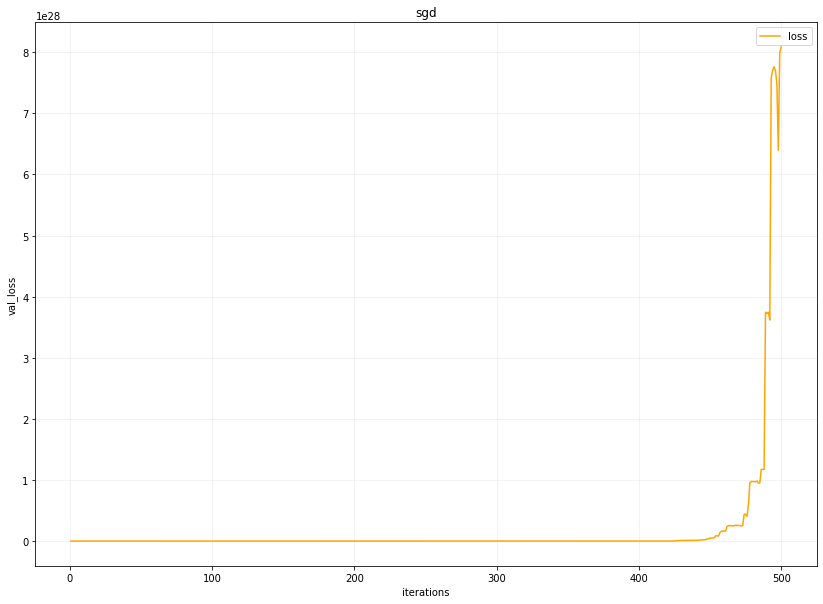

mse on test: 1.0608058688136765e+29, r2 on test: -7.854003442669325e+25


In [40]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc, val_loss, label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('sgd')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [41]:
linreg = LinearRegression(optimizer='adagrad')
linreg.fit(X_train, y_train, max_iter=max_iter)

iter_num: 0	mse: 4734.919624142121, r2: -0.027645151077886787
iter_num: 1	mse: 4732.688472244619, r2: -0.027160912144432503
iter_num: 2	mse: 4730.023713401821, r2: -0.026582565156316518
iter_num: 3	mse: 4728.374813953759, r2: -0.026224695613235927
iter_num: 4	mse: 4727.160238114416, r2: -0.025961089666145742
iter_num: 5	mse: 4726.196369120559, r2: -0.02575189597830363
iter_num: 6	mse: 4725.3969628930545, r2: -0.02557839653192473
iter_num: 7	mse: 4724.714023787086, r2: -0.02543017457327701
iter_num: 8	mse: 4724.117985802298, r2: -0.025300813233793296
iter_num: 9	mse: 4723.589317004402, r2: -0.02518607339240031
iter_num: 10	mse: 4723.114428058959, r2: -0.02508300568252886
iter_num: 11	mse: 4722.6834771702715, r2: -0.0249894740861627
iter_num: 12	mse: 4722.289104607568, r2: -0.024903881281225893
iter_num: 13	mse: 4721.925660724237, r2: -0.024825001094434418
iter_num: 14	mse: 4721.588712966676, r2: -0.024751871504766543
iter_num: 15	mse: 4721.274718892416, r2: -0.024683723676821367
iter_nu

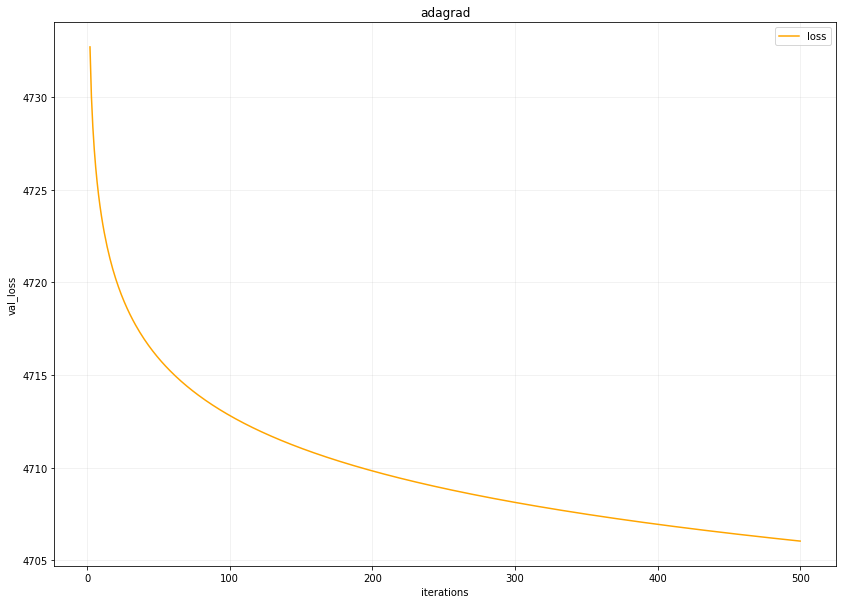

mse on test: 1400.0200914418888, r2 on test: -0.03654805664750227


In [42]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.title('adagrad')
plt.grid(alpha=0.2)
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [43]:
linreg = LinearRegression(optimizer='rmsprop')
linreg.fit(X_train, y_train, max_iter=max_iter)

iter_num: 0	mse: 4734.919624142121, r2: -0.027645151077886787
iter_num: 1	mse: 4737.595016552115, r2: -0.028225805926459735
iter_num: 2	mse: 4730.869520267272, r2: -0.02676613518348181
iter_num: 3	mse: 4725.778960714145, r2: -0.02566130357992691
iter_num: 4	mse: 4721.214124997146, r2: -0.02467057265682482
iter_num: 5	mse: 4716.881184018331, r2: -0.023730171099830555
iter_num: 6	mse: 4712.736605351601, r2: -0.022830650831649146
iter_num: 7	mse: 4708.979452578116, r2: -0.022015215695254442
iter_num: 8	mse: 4705.077538389953, r2: -0.021168362208039193
iter_num: 9	mse: 4701.311460386123, r2: -0.020350989980751022
iter_num: 10	mse: 4697.2686767365585, r2: -0.019473562834332325
iter_num: 11	mse: 4693.968562325848, r2: -0.01875732119954776
iter_num: 12	mse: 4689.999340199957, r2: -0.017895859507479184
iter_num: 13	mse: 4686.127745285831, r2: -0.017055586375881893
iter_num: 14	mse: 4682.128952261715, r2: -0.016187706752235353
iter_num: 15	mse: 4678.494820997899, r2: -0.015398971637789138
iter_

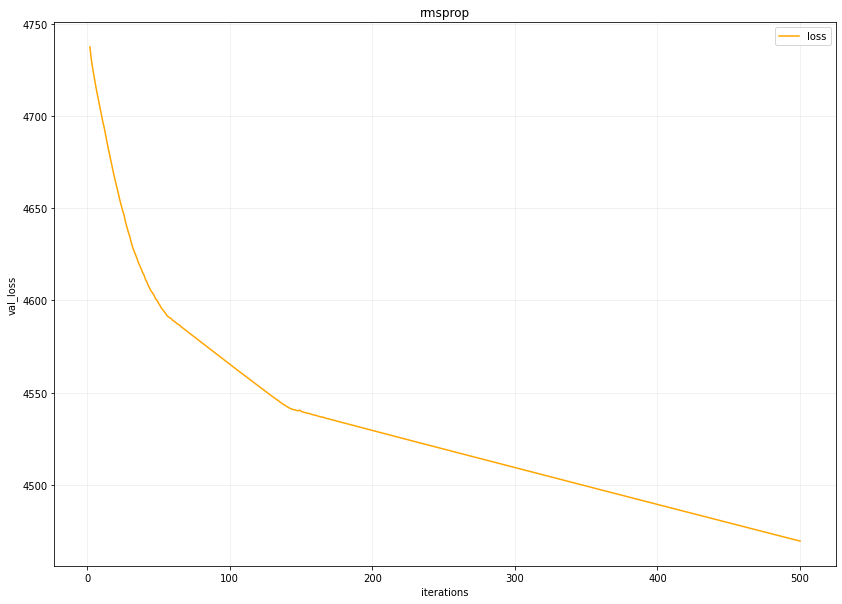

mse on test: 1458.7538624304236, r2 on test: -0.0800334155719189


In [44]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('rmsprop')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [45]:
linreg = LinearRegression(optimizer='adam')
linreg.fit(X_train, y_train, max_iter=max_iter)

iter_num: 0	mse: 4734.919624142121, r2: -0.027645151077886787
iter_num: 1	mse: 4737.595016552115, r2: -0.028225805926459735
iter_num: 2	mse: 4730.869520267272, r2: -0.02676613518348181
iter_num: 3	mse: 4725.778960714145, r2: -0.02566130357992691
iter_num: 4	mse: 4721.214124997146, r2: -0.02467057265682482
iter_num: 5	mse: 4716.881184018331, r2: -0.023730171099830555
iter_num: 6	mse: 4712.736605351601, r2: -0.022830650831649146
iter_num: 7	mse: 4708.979452578116, r2: -0.022015215695254442
iter_num: 8	mse: 4705.077538389953, r2: -0.021168362208039193
iter_num: 9	mse: 4701.311460386123, r2: -0.020350989980751022
iter_num: 10	mse: 4697.2686767365585, r2: -0.019473562834332325
iter_num: 11	mse: 4693.968562325848, r2: -0.01875732119954776
iter_num: 12	mse: 4689.999340199957, r2: -0.017895859507479184
iter_num: 13	mse: 4686.127745285831, r2: -0.017055586375881893
iter_num: 14	mse: 4682.128952261715, r2: -0.016187706752235353
iter_num: 15	mse: 4678.494820997899, r2: -0.015398971637789138
iter_

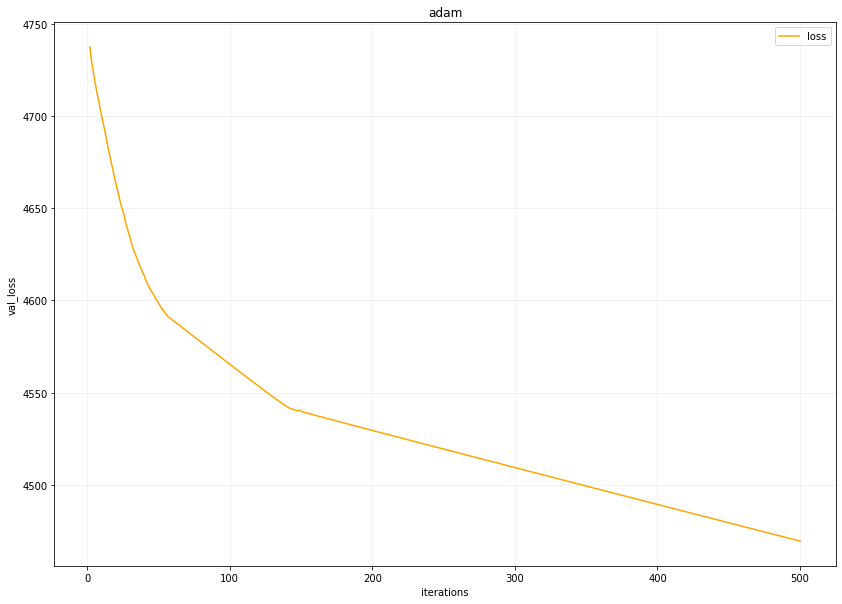

mse on test: 1458.7538624304236, r2 on test: -0.0800334155719189


In [46]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('adam')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [47]:
linreg = LinearRegression(r1=0.01, optimizer='adam')
linreg.fit(X_train, y_train, max_iter=max_iter)

iter_num: 0	mse: 4734.919624142121, r2: -0.027645151077886787
iter_num: 1	mse: 4737.619524348798, r2: -0.028231124985794054
iter_num: 2	mse: 4730.910049420467, r2: -0.0267749314442558
iter_num: 3	mse: 4725.83767665264, r2: -0.025674047016833068
iter_num: 4	mse: 4721.292827101565, r2: -0.02468765379914739
iter_num: 5	mse: 4716.9806188097355, r2: -0.023751751969063095
iter_num: 6	mse: 4712.861901058106, r2: -0.02285784443480643
iter_num: 7	mse: 4709.125639512338, r2: -0.02204694343427205
iter_num: 8	mse: 4705.231220880934, r2: -0.021201716748179056
iter_num: 9	mse: 4701.507500557919, r2: -0.0203935376368789
iter_num: 10	mse: 4697.455160538947, r2: -0.019514036420051006
iter_num: 11	mse: 4694.263315194755, r2: -0.01882129300488833
iter_num: 12	mse: 4690.270384006315, r2: -0.01795468560706337
iter_num: 13	mse: 4686.434817155336, r2: -0.017122231840383417
iter_num: 14	mse: 4682.4328427447845, r2: -0.01625366174327514
iter_num: 15	mse: 4678.839941331324, r2: -0.015473874965687973
iter_num: 1

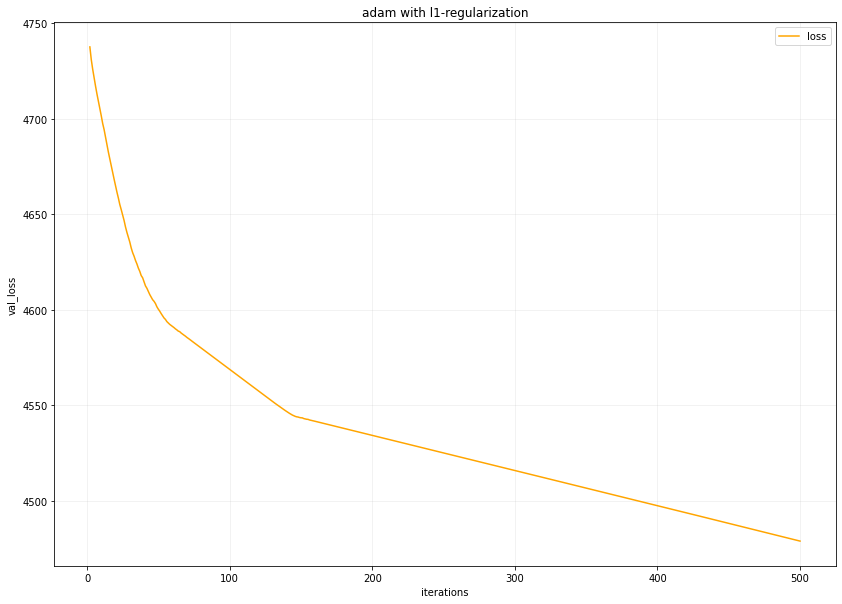

mse on test: 1460.7359085264936, r2 on test: -0.08150088453299031


In [48]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('adam with l1-regularization')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [49]:
linreg = LinearRegression(r2=0.01, optimizer='adam')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.01)

iter_num: 0	mse: 4734.919624142121, r2: -0.027645151077886787
iter_num: 1	mse: 4733.904589362432, r2: -0.027424852603503913
iter_num: 2	mse: 4733.177405910705, r2: -0.027267028055796505
iter_num: 3	mse: 4732.594122899945, r2: -0.02714043499714025
iter_num: 4	mse: 4732.066007086796, r2: -0.027025815173009615
iter_num: 5	mse: 4731.580966675709, r2: -0.026920544235782273
iter_num: 6	mse: 4731.071344434436, r2: -0.026809938171329595
iter_num: 7	mse: 4730.611176324272, r2: -0.0267100654037582
iter_num: 8	mse: 4730.112800718349, r2: -0.02660190025725173
iter_num: 9	mse: 4729.63708912367, r2: -0.026498654003378475
iter_num: 10	mse: 4729.208148883541, r2: -0.026405558788916483
iter_num: 11	mse: 4728.726321869065, r2: -0.026300985272491806
iter_num: 12	mse: 4728.256243168887, r2: -0.026198961556101574
iter_num: 13	mse: 4727.755132150223, r2: -0.026090202728210388
iter_num: 14	mse: 4727.288885576387, r2: -0.025989010718874717
iter_num: 15	mse: 4726.833706949065, r2: -0.025890220845683265
iter_nu

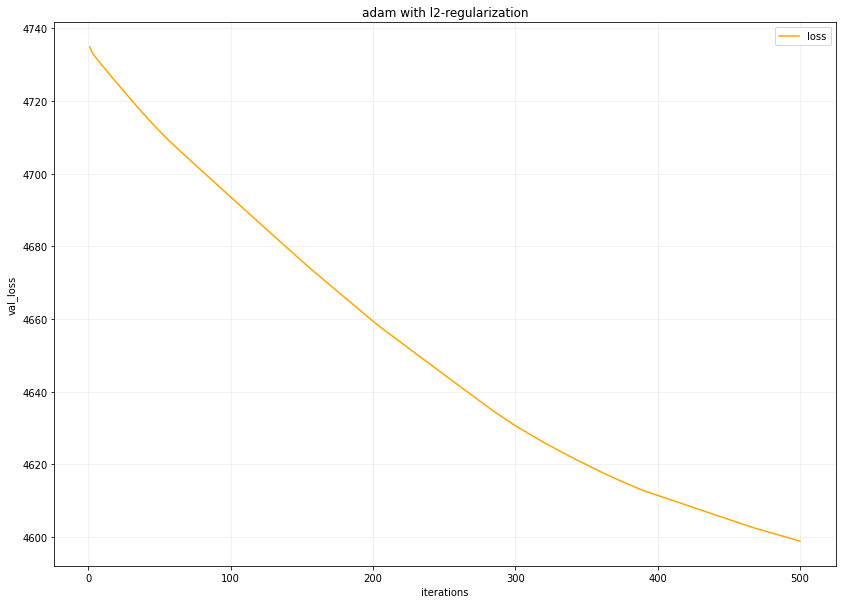

mse on test: 1444.6336861967266, r2 on test: -0.06957910757732066


In [50]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc, val_loss, label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('adam with l2-regularization')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [51]:
linreg.get_weights()

[2.1901475566412114,
 3.3873678949670705,
 -4.316497584206859,
 5.088440563974356,
 2.1073615686401146,
 2.6230355313778704,
 3.633645370505109,
 -1.2377981937263918,
 -0.4797084261485625,
 4.431071865738481,
 2.2373211581999333,
 1.8553172521379393,
 -1.5895792877450248,
 -0.45411645199225653,
 0.0532337896946547,
 -2.2651712316426083,
 2.67405206001338,
 -1.7886277214778712,
 -0.89330036429383,
 -1.6707685226141968,
 -2.227103479022469,
 -1.930238711409632,
 1.5800000032530108,
 -1.3172784306496506,
 2.8932797902550895,
 -3.132318204570896,
 -0.3524728497545032,
 -1.7645248470497623,
 1.3863255899025655]

# Cross Validation

In [52]:
def CV(X, y, l1_list = [], l2_list = [], optimizer = 'sgd', iter_count = 3, fold_count=5):
    assert len(X) == len(y)
    # Разбиваем на фолды
    fold_size = math.ceil(len(X) / fold_count)
    fold_list = []
    for i in range(fold_count):
        fold = {
            'X': [],
            'y_true': [],
            'y_pred': [],
            'mse_train': [],
            'mse_test': [],
            'r2_train': [],
            'r2_test': [],
            'loss': [],
            'l1': [],
            'l2': [],
        }
        min_fold_size = min((i + 1)*fold_size, len(X))
        fold['X'] = X[i*fold_size:min_fold_size]
        fold['y_true'] = y[i*fold_size:min_fold_size]
        fold_list.append(fold)
    # Обучаем
    for i in range(fold_count):
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        for j in range(fold_count):
            if i != j:
                X_train += fold_list[j]['X']
                y_train += fold_list[j]['y_true']
            else:
                X_test += fold_list[j]['X']
                y_test += fold_list[j]['y_true']
        for l1 in l1_list:
            for l2 in l2_list:
                print('test_fold_num:', i, ' | l1:', l1, ' | l2:', l2)
                model = LinearRegression(optimizer=optimizer, r1=l1, r2=l2)
                model.fit(X_train, y_train, max_iter=iter_count)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                fold_list[i]['y_pred'].append(y_pred_test)
                # Считаем метрики
                fold_list[i]['mse_train'].append(mse(y_pred_train, y_train))
                fold_list[i]['mse_test'].append(mse(y_pred_test, y_test))
                fold_list[i]['r2_train'].append(r2(y_pred_train, y_train))
                fold_list[i]['r2_test'].append(r2(y_pred_test, y_test))
                fold_list[i]['loss'].append(model.get_losses())
                fold_list[i]['l1'].append(l1)
                fold_list[i]['l2'].append(l2)
    return fold_list

In [53]:
lst = ['adam']#, 'adagrad', 'msprop', 'adam']
iter_num = 500
fold_count = 5
for optimizer in lst:
  cv_res = {
    'optimizer': '',
    'res': None,
  }
  cv_res['optimizer'] = optimizer
  cv_res['res'] = CV(X_train, y_train, l1_list=[0.01, 0.1], l2_list=[0.01, 0.1], iter_count = iter_num, optimizer=optimizer, fold_count=fold_count)

Выходные данные были обрезаны до нескольких последних строк (5000).
iter_num: 9	mse: 4906.481780655, r2: -0.02091840388863675
iter_num: 10	mse: 4902.625150506692, r2: -0.020115933835466837
iter_num: 11	mse: 4899.089662257716, r2: -0.019380285527478947
iter_num: 12	mse: 4895.461036108038, r2: -0.01862525750890076
iter_num: 13	mse: 4892.0263757734465, r2: -0.01791058901456033
iter_num: 14	mse: 4888.789587719174, r2: -0.017237092883967797
iter_num: 15	mse: 4885.943464318355, r2: -0.016644884476898714
iter_num: 16	mse: 4882.396824801907, r2: -0.015906915863914906
iter_num: 17	mse: 4879.51664905379, r2: -0.015307621999362198
iter_num: 18	mse: 4876.437261120013, r2: -0.01466687696965474
iter_num: 19	mse: 4873.584031413168, r2: -0.014073189914762363
iter_num: 20	mse: 4870.744213218995, r2: -0.01348229346640295
iter_num: 21	mse: 4867.987236402777, r2: -0.012908634275031083
iter_num: 22	mse: 4865.508417260822, r2: -0.012392852866872195
iter_num: 23	mse: 4863.174335831052, r2: -0.011907187823291

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


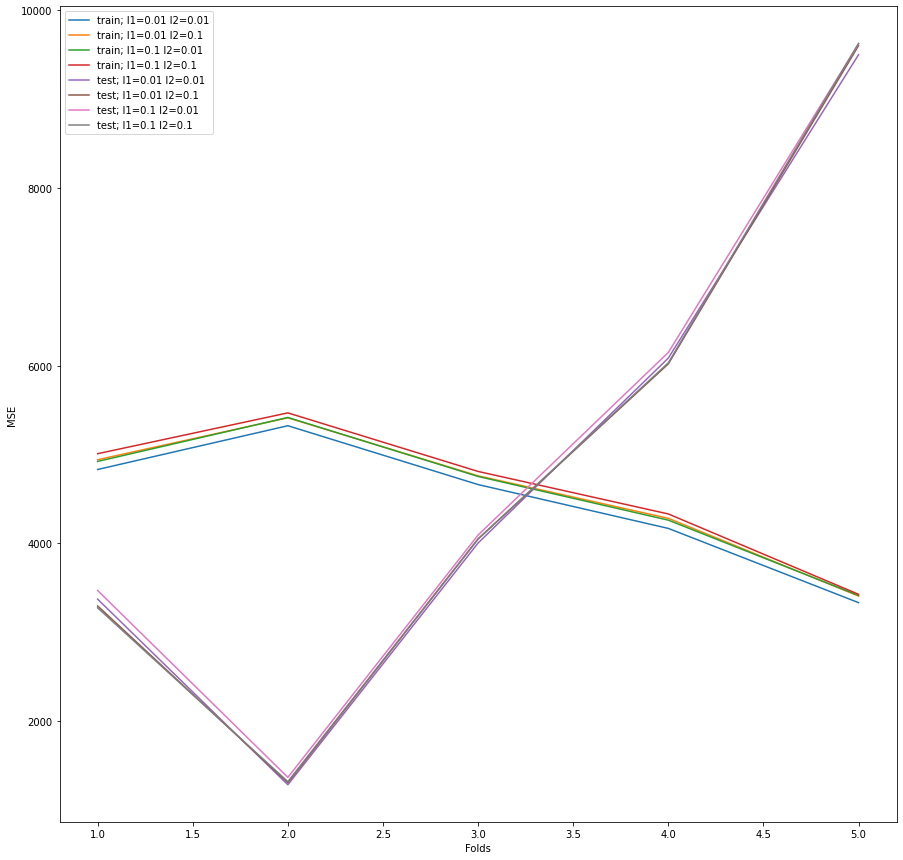

In [54]:
legends = []
plt.figure(figsize=(15, 15))
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('train; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['mse_train'][j] for i in range(fold_count)], '-')
plt.subplot()
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('test; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['mse_test'][j] for i in range(fold_count)], '-')
plt.xlabel("Folds")
plt.ylabel("MSE")
plt.legend(tuple(legends))   
plt.show()

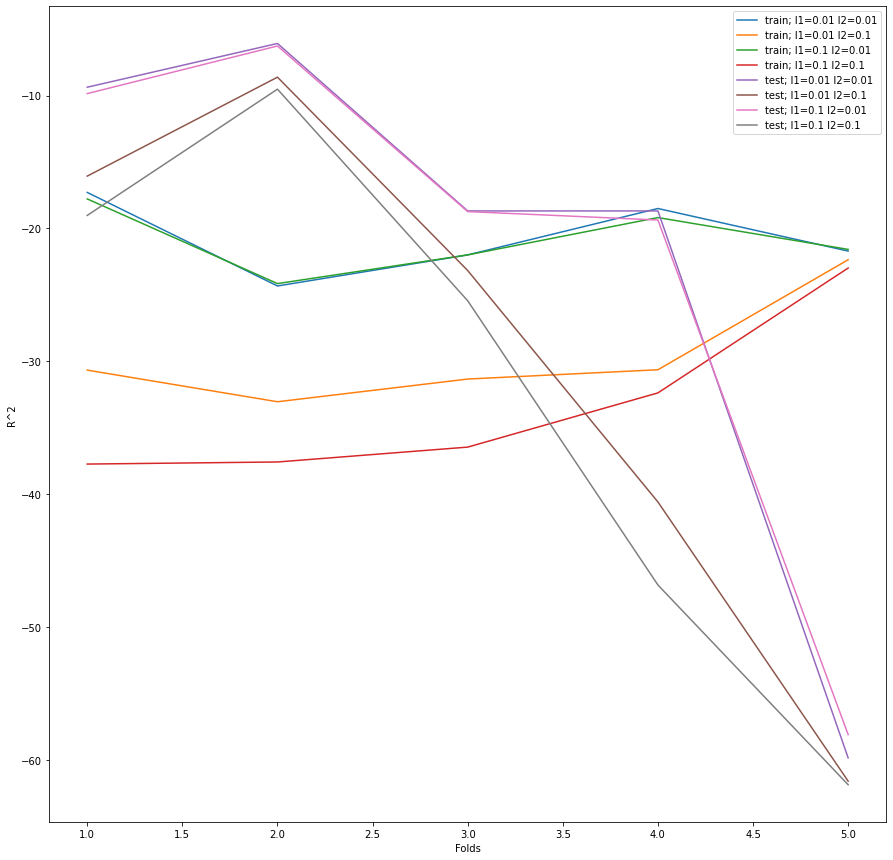

In [55]:
legends = []
plt.figure(figsize=(15, 15))
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('train; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['r2_train'][j] for i in range(fold_count)], '-')
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('test; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['r2_test'][j] for i in range(fold_count)], '-')
plt.xlabel("Folds")
plt.ylabel("R^2")
plt.legend(tuple(legends))   
plt.show()

In [ ]:
# Как нам кажется, в среднем лучше себя ведет смешанная регуляризация с коэффициентами l1=0.1 и l2=0.2